The idea of the project came from a necessity to know how individual items of the menu perform in sales of a rapidly growing Food Startup. It was unclear what to expect in the future and what to put emphasis on when updating the menu. The project is to tell the story behind the data. The additional use of the project that came along was to automate the supply chain by forecasting use of ingredients from all-messy collection of sales data (in food business the more high-end the cuisine is, the more complex the supply chain gets as individual ingredients may take days in preparation since the order is placed). To avoid sensitive data, let's exclude the corporate order inputs but keep the corresponding modules as part of the code.

Starting off with importing all the necessary libraries and modules

In [1]:
#!/usr/bin/env python3
import math
import matplotlib.pyplot as plt
import re
import numpy as np
import os
import pandas as pd
from PIL import Image
import pytesseract #optical character recognition model
from pdf2image import convert_from_path
import tempfile
import fitz
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

Declaring global variables, setting up methods

In [2]:
current_dir = os.path.dirname(os.path.abspath("ingredientUseForecast.ipynb"))
pd.set_option("mode.copy_on_write", True)
files_and_dirs = os.listdir(current_dir)
pytesseract.pytesseract.tesseract_cmd = r"/opt/homebrew/bin/tesseract"


daily_distribution={'Monday':0.15,'Tuesday':0.15,'Wednesday':0.10,'Thursday':0.20,'Friday':0.20,'Saturday':0.15,'Sunday':0.10} #distribution of weekly sales by days; will be explained further down
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
modifiers_of_position_in_combo = {'Extra hot','No pickles', 'No salad','No sauce', 'Toncutlet sauce', 'Curry sauce'} #will rarely variate and is embedded in code for simplicity
corporate_counter=0

The project consists of several files for a user to interact with. 'unit_category' as a list of menu items we want to look at and whether to forecast their sales or to use an adapted mean; 'ingredients_base' is tables of ingredients and amounts for each item; 'measure conversion' is a table with ingredients and the ratio units of stock measure vs units of measure in recipes;

The sales data are contained in such: the 'items-...' file where each record represents individual sale; 'rs-items_sold...' a file with 'Delivery' sales in one of the shops, requires separate integration; + two types of .pdf files, containing Corporate orders from two platforms, these files require image-text recognition and separate integration too.

In [3]:
def pull_unit_categories():
    df = pd.read_csv(current_dir+'/'+'unit_category.csv', encoding='utf-8' , sep = ',', low_memory=False)
    shops = df['Location'].unique()
    units_to_forecast = {shop: [] for shop in shops}
    units_to_baseline = {shop: [] for shop in shops}
    units_to_ignore = {shop: [] for shop in shops}

    for _, row in df.iterrows():
        shop = row['Location']
        category = row['Category']
        item = row['Item']
        if category == 'Forecast':
            units_to_forecast[shop].append(item)
        elif category == 'Baseline':
            units_to_baseline[shop].append(item)
        elif category == 'Ignore':
            units_to_ignore[shop].append(item)

    return units_to_forecast, units_to_baseline, units_to_ignore
units_to_forecast, units_to_baseline, units_to_ignore = pull_unit_categories()

In [4]:
def pull_sales():
    df = pd.DataFrame()
    for filename in files_and_dirs:
        if filename.startswith('items-'):
            df = pd.concat([df, pd.DataFrame(pd.read_csv(current_dir+'/'+filename, encoding='utf-8' , sep = ',', low_memory=False))], axis = 'rows', ignore_index=True)
    if df.empty:
        raise Exception("No Sales Record file(s) found in the algorithm directory")
    print(df)
    df = df.sort_values(by='Date')
    df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d', errors='coerce').dt.date
    return df

For data cleaning purposes, will create a function to adapt data to naming conventions:

In [5]:
def df_no_emoji(df_input, columns):
    for col in columns:
        for name in df_input[col].unique().tolist():
            if not pd.notna(name):
                continue
            newname = name.strip().replace('CanoWater', 'Water').replace('Shop1','').replace('  ',' ')
            for i in name:
                if ord(i) > 2070:
                    newname = newname.replace(i, '')
            if ',' not in newname:
                df_input.loc[df_input[col] == name, col] = newname.strip().casefold().capitalize()
            else:
                substr = newname.split(',')
                df_input.loc[df_input[col] == name, col] = ','.join([s.strip().casefold().capitalize() for s in substr])
    return df_input

Another data cleaning procedure is to adapt sales of 'Combo' item, where a single sale record represents more than 1 item sold:

In [6]:
def combo_handling(df, main_pos, mods):
    combos = pd.concat([df.loc[df['Item'].str.find('Combo') != -1],df.loc[df['Item'].str.find('combo') != -1]] ,axis = 0, ignore_index=True)
    combos = pd.concat([combos, df.loc[df['Item'].str.find('COMBO') != -1]], axis=0,ignore_index=True)
    df_combos = pd.DataFrame()
    for i in range(0,len(combos)):
        combo = combos.iloc[i]
        modifiers = {item.strip() for item in combo['Modifiers Applied'].split(',')}
        for each in modifiers:
            if each in mods:
                continue
            if each in main_pos:
                modi = list(modifiers.intersection(mods))[0] if len(modifiers.intersection(mods))>0 else np.nan
                new_item = {'Date': combo['Date'], 'Time':combo['Time'],
                            'Item': each, 'Qty': combo['Qty'],'Modifiers Applied':modi, 'Location': combo['Location'],
                            'Itemisation Type': combo['Itemisation Type']}
            else:
                new_item = {'Date': combo['Date'], 'Time':combo['Time'],
                            'Item': each, 'Qty': combo['Qty'], 'Location':combo['Location'], 'Itemisation Type':combo['Itemisation Type']}
            df_combos = pd.concat([df_combos, pd.DataFrame([new_item])], axis = 'rows', ignore_index=True)
    df = df.loc[(df['Item'].str.find('Combo') == -1)&(df['Item'].str.find('combo') == -1)&(df['Item'].str.find('COMBO') == -1)]
    return pd.concat([df, df_combos], axis = 0, ignore_index=True)


Proceeding to pull sales data:

In [7]:
def shop2_del_handling(df_input, total_count):
    df_shop2_del = pd.DataFrame()

    dates = pd.Series(df_input['Date'])

    dates = [day.strftime('%d-%m-%Y') for day in dates.unique().tolist()]

    if 'rs-items_sold-report_{}_{}.csv'.format(dates[0], dates[-1]) in files_and_dirs:
        df_shop2_del = pd.read_csv(current_dir+'/'+'rs-items_sold-report_{}_{}.csv'.format(dates[0],dates[-1]))
    elif not total_count:
        return df_shop2_del
    else:
        for date1 in dates:
            for date2 in dates:
                if 'rs-items_sold-report_{}_{}.csv'.format(date1, date2) in files_and_dirs:
                    to_app = pd.read_csv(current_dir+'/'+'rs-items_sold-report_{}_{}.csv'.format(date1,date2))
                    df_shop2_del = pd.concat([df_shop2_del, to_app], ignore_index=True)
    df_shop2_del = df_shop2_del[['Item name', 'Quantity']]

    for name in df_shop2_del['Item name'].unique().tolist():
        #adjustment to naming conventions
        newname = name.casefold().capitalize()
        newname = newname.replace('Crispy chicken skin','Chicken skin')
        newname = newname.replace('Cold sake can','Sake can')
        newname = newname.replace('Butter zucchinis','Grilled zucchinis')
        newname = newname.replace('Green tea','Ice green tee')
        newname = newname.replace('Coca-cola','Coca cola')
        df_shop2_del.loc[df_shop2_del['Item name'] == name, 'Item name'] = newname
    return df_shop2_del

The two platforms in question have a different way of presenting the orders and do not provide accounting instruments, therefore processing requires separate algorithms:

In [8]:
def justeat_handling(filename):
    os.makedirs(current_dir + '/temp_images', exist_ok=True)

    images_text = []

    pages = convert_from_path(current_dir + '/' + filename,  poppler_path="/opt/homebrew/bin")
    df_catering = pd.DataFrame()
    for page_num, page in enumerate(pages):
        with tempfile.NamedTemporaryFile(dir=(current_dir + '/temp_images'), delete=False) as temp_image:
            page.save(temp_image, 'JPEG')
            temp_image_path = temp_image.name

        img = Image.open(temp_image_path)
        text = pytesseract.image_to_string(img)
        images_text.append(text)

        os.remove(temp_image_path)
    for item in images_text:
        item = item.replace('\n\n', '\n').split('\n')[1:4]
        item.pop(1)
        item[0] = item[0].replace('Can\'o\'Water',' ').replace('-',' ')
        item[1] = pd.to_datetime((item[1][0:-2]+'20'+item[1][-2:]).replace('/','-'), format='%d-%m-%Y', errors='coerce')
        time = '10:00:0'+str(corporate_counter%10)
        item_key = {'Date':item[1],'Time':time,'Item':item[0],'Qty':1,'Modifiers Applied':np.nan,'Location':'Shop1','Itemisation Type':'Catering'}
        df_catering = pd.concat([df_catering,pd.DataFrame([item_key])],ignore_index=True)
    df_catering['Date'] = df_catering['Date'].dt.date
    return df_catering

In [9]:
def feedr_handling(filename):
    df_catering = pd.DataFrame()
    feedr = fitz.open(filename)
    general_data = feedr.load_page(0).get_text()
    date_pattern = r'Date: (\d{2} \w{3} \d{2})'
    match = re.search(date_pattern, general_data)
    date = match.group(1)
    date = pd.to_datetime(date, format='%d %b %y')
    store_name_pattern = re.compile(r'Total Value: £(?P<total_value>\d+\.\d{2})\n(?P<location_name>.+)\n')
    match = re.search(store_name_pattern, general_data)
    store_name = match.group('location_name')
    time = '10:00:0'+str(corporate_counter%10)
    for pagenum in range(len(feedr)):
        page = feedr.load_page(pagenum)
        text = page.get_text()
        text = text[text.index('Credits')+7 if 'Credits' in text else 0:]
        pattern = re.compile(r'(?P<issuer>[A-Za-z\s]+)\s(?P<qty>\d+)\s(?P<description>(?:.|\n)+?)\s*\s#(?P<item_number>\d+)\n(?P<price>\d+\.\d{2})')
        matches = pattern.findall(text.strip())
        for match in matches:
            issuer, qty, name, item_number, price = match
            if '(' in name:
                name = name[0:name.index('(')].replace('\'','')
            name = name.strip().casefold().capitalize()
            item_key = {'Date': date, 'Time': time, 'Item': name, 'Qty': int(qty), 'Modifiers Applied': np.nan,
                    'Location': store_name, 'Itemisation Type': 'Catering'}
            df_catering = pd.concat([df_catering, pd.DataFrame([item_key])], ignore_index=True)
    df_catering['Date'] = df_catering['Date'].dt.date
    return df_catering

And a general .pdf sorting function:

In [10]:
def corporate_handling(df):
    global corporate_counter
    df_to_append = pd.DataFrame()
    for filename in files_and_dirs:
        if '.pdf' in filename:
            corporate_counter+=1
            document = fitz.open(filename)
            page = document.load_page(0)
            text = page.get_text()
            if not text:
                df_to_append = pd.concat([df_to_append,justeat_handling(filename)],ignore_index=True)
            else:
                df_to_append = pd.concat([df_to_append,feedr_handling(filename)],ignore_index=True)
    try:
        result = pd.concat([df_no_emoji(df_to_append, ['Item']),df], ignore_index=True)
        result['Date'] = pd.to_datetime(result['Date'])
        result['Date'] = result['Date'].dt.date
        return result
    except Exception:
        print("No catering records found")
        return df

Having sales records clean, we can proceed with a function to pivot by day sales of each item:

In [11]:

def df_pivoting(df_input, total_count= False):
    for item in df_input['Item'].unique().tolist():
        df_input.loc[df_input['Item'] == item, 'Item'] = item.casefold().capitalize()

    df_shop2_del = pd.DataFrame()
    if 'Shop2' in df_input['Location'].unique().tolist():
        df_shop2_del = shop2_del_handling(df_input, total_count)

    df_pivot = pd.DataFrame()
    lst = df_input['Item'].unique().tolist()
    for item in lst :
        if df_shop2_del.empty:
            quantity_sum = 0
        else:
            quantity_sum = df_shop2_del.loc[df_shop2_del['Item name'] == item, 'Quantity'].sum()
        item_key = {'Name': item,
                    'Quantity_InHouse': df_input.loc[(df_input['Item'] == item)
                                                     & ((df_input['Itemisation Type'] == 'Physical Item')
                                                        | (df_input['Itemisation Type'].isnull()))]['Qty'].sum(),
                    'Quantity_OnDelivery': df_input.loc[(df_input['Item'] == item)
                                                        & (df_input[
                                                               'Itemisation Type'] == 'Prepared Food and Beverage')][
                                                        'Qty'].sum() + quantity_sum,
                    'Quantity_Corporate': df_input.loc[(df_input['Item'] == item)
                                                     & (df_input['Itemisation Type'] == 'Catering')]['Qty'].sum(),
                    }

        # 'Itemisation Type' == 'Prepared Food and Beverage' -> Delivery
        # 'Itemisation Type' == 'Physical Item' -> In House
        # 'Itemisation Type' == Blank -> Custom Amount
        df_input.loc[df_input['Modifiers Applied']=='Toncutlet sauce', 'Modifiers Applied'] = 'Toncutlet'
        df_input.loc[df_input['Modifiers Applied']=='Curry sauce', 'Modifiers Applied'] = 'Curry'
        modifier_check = df_input.loc[df_input['Item'] == item, 'Modifiers Applied'].unique().tolist()
        if len(modifier_check) == 1 and type(modifier_check[0]) is float:
            df_pivot = pd.concat([df_pivot, pd.DataFrame([item_key])], axis=0, ignore_index=True)
            continue
        modifiers_set = set()
        for modifier in modifier_check:
            if type(modifier) is float:
                continue
            if ',' in modifier:
                modifiers_set.update([item.strip() for item in modifier.split(',')])
            else:
                modifiers_set.add(modifier.strip())
        for modifier in modifiers_set:
            number_of_modifier_applied = df_input.dropna(subset=['Modifiers Applied']).loc[(df_input['Item'] == item)
                                                                  & (df_input['Modifiers Applied'].str.find(modifier) != -1)]['Qty'].sum()
            item_key[modifier] = number_of_modifier_applied
        df_pivot = pd.concat([df_pivot, pd.DataFrame([item_key])], axis=0, ignore_index=True)

    if not df_shop2_del.empty:
        for delitem in df_shop2_del['Item name'].unique().tolist():
            if delitem not in lst:
                item_key = {'Name': delitem,
                            'Quantity_InHouse': 0,
                            'Quantity_OnDelivery': df_shop2_del.loc[df_shop2_del['Item name'] == delitem, 'Quantity'].sum()
                            }
                df_pivot = pd.concat([df_pivot, pd.DataFrame([item_key])], axis=0, ignore_index=True)
    return df_pivot

With a summary of sales for each item we can calculate amounts of ingredients used:

In [12]:
def ingredients_pivoting(store_pivot, ingredients_base_file):
    ingredients_count = pd.DataFrame(columns = ['Ingredient', 'Qty'])
    numerical_columns = [col for col in
                         ['Qty', 'Quantity', 'Quantity_InHouse', 'Quantity_OnDelivery', 'Quantity_Corporate'] if
                         col in store_pivot.columns]
    for item_n in range(0,len(store_pivot)):
        if store_pivot.loc[item_n,'Name'] in ingredients_base_file.sheet_names:
            item_info = ingredients_base_file.parse(sheet_name=store_pivot.loc[item_n,'Name'])
            for ingredient_n in range(0,len(item_info)):
                number_of_items = store_pivot.loc[item_n,numerical_columns].sum()
                qty_of_ingredient = item_info.loc[ingredient_n, 'Quantity']
                count = number_of_items*qty_of_ingredient
                if item_info.loc[ingredient_n, 'Ingredients'] in ingredients_count['Ingredient'].tolist():
                    ingredients_count.loc[ingredients_count['Ingredient'].tolist().index(item_info.loc[ingredient_n, 'Ingredients']), 'Qty'] += count
                else:
                    ingredients_count.loc[len(ingredients_count)] = {'Ingredient': item_info.loc[ingredient_n, 'Ingredients'] , 'Qty': count}
            for modifier in store_pivot.drop(columns=numerical_columns,inplace=False).columns[1:]:#store_pivot.columns[4:]:
                if not modifier in item_info.columns:
                    continue
                if not pd.isna(store_pivot.loc[item_n,modifier]):
                    for ingredient_addition_n in range(0,len(item_info)):
                        if not pd.isna(item_info.loc[ingredient_addition_n, modifier]):
                            count = store_pivot.loc[item_n, modifier]*item_info.loc[ingredient_addition_n, modifier]
                            if item_info.loc[ingredient_addition_n,'Ingredients'] in ingredients_count['Ingredient'].tolist():
                                ingredients_count.loc[ingredients_count['Ingredient'].tolist().index(item_info.loc[ingredient_addition_n, 'Ingredients']), 'Qty'] += count
                            else:
                                ingredients_count.loc[len(ingredients_count)] = {'Ingredient': item_info.loc[ingredient_addition_n,'Ingredients'], 'Qty': count}
        else:
            count = store_pivot.loc[item_n, numerical_columns].sum()
            if store_pivot.loc[item_n,'Name'] in ingredients_count['Ingredient'].tolist():
                ingredients_count.loc[ingredients_count['Ingredient'].tolist().index(store_pivot.loc[item_n, 'Name']), 'Qty'] += count
            else:
                ingredients_count.loc[len(ingredients_count)] = {'Ingredient': store_pivot.loc[item_n,'Name'], 'Qty': count}
    return ingredients_count

Both functions are designed to summarise individual days, for large datasets we need merge functions to put reports together:

In [13]:
def append_sales_count(total_df, range_df, day):
    for platform in ['Quantity_InHouse', 'Quantity_OnDelivery','Quantity_Corporate']:
        total_df.loc[len(total_df), ['Day','Platform','Day of week']] = [day.strftime('%Y-%m-%d'), platform, days[day.weekday()]]
        total_df.loc[len(total_df)-1, 'Platform'] = platform
        for numunit in range(0, len(range_df)):
            total_df.loc[len(total_df)-1,range_df.loc[numunit, 'Name']] = 0+range_df.loc[numunit,platform]
    total_df = total_df.fillna(0)
    return total_df

In [14]:
def append_ingredients_pivot(total_df, range_df, day):
    for numingr in range(0, len(total_df)):
        position = range_df.index[range_df['Ingredient'] == total_df.loc[numingr,'Ingredient']]
        total_df.loc[numingr, day] = 0
        if not position.empty:
            total_df.loc[numingr, day] += range_df.loc[position[0],'Qty']
    return total_df

Then, for the specific pivot (later forecasted) of used ingredients, will adapt the measure to stockable units for ordering

In [15]:
def measure_change(ingredients_df, conversion_table, last_week):
    ingredients_df = pd.merge(ingredients_df,last_week, on='Ingredient')
    for each in days:
        ingredients_df[each]=ingredients_df['Qty']*daily_distribution[each]
    ingredients_df.insert(2, 'Rounded %', '+0.0%')
    ingredients_df.insert(3, 'From last week %', '+0.0%')
    ingredients_df['Last_week'] = ingredients_df['Last_week'].astype(float)
    for num_ingr in range(len(ingredients_df['Ingredient'])):
        sum_rounded=0
        try:
            for col in ingredients_df.drop(columns=['Rounded %','From last week %'],inplace=False).columns[1:]:
                x= float(ingredients_df.loc[num_ingr,col])/float(conversion_table.loc[conversion_table['Ingredient'] == ingredients_df.loc[num_ingr, 'Ingredient'],'Order unit ratio'].tolist()[0])
                if col != 'Qty' and col != 'Last_week':
                    x=round(x,2)
                    sum_rounded+=x
                ingredients_df.loc[num_ingr,col] = x
            if ingredients_df.loc[num_ingr,'Qty'] != 0:
                add_on = (math.ceil(sum_rounded)-ingredients_df.loc[num_ingr,'Qty'])/ingredients_df.loc[num_ingr,'Qty']
                add_on_last_week = (math.ceil(sum_rounded)-ingredients_df.loc[num_ingr,'Last_week'])/ingredients_df.loc[num_ingr,'Last_week']
            else:
                add_on = 0
                add_on_last_week = 0
            ingredients_df.loc[num_ingr, 'Rounded %'] = f"{add_on:+.2%}"
            ingredients_df.loc[num_ingr, 'From last week %'] = f"{add_on_last_week:+.2%}"
            ingredients_df.loc[num_ingr, 'Qty'] = math.ceil(sum_rounded)
        except Exception as e:
            #print('No ingredient {} found in conversion table'.format(ingredients_df.loc[num_ingr, 'Ingredient']))
            for col in ingredients_df.drop(columns=['Rounded %','From last week %'],inplace=False).columns[1:]:
                x= float(ingredients_df.loc[num_ingr,col])
                if col != 'Qty' and col !='Last_week':
                    x=round(x,2)
                    sum_rounded+=x
                ingredients_df.loc[num_ingr,col] = x
            if np.isnan(sum_rounded):
                sum_rounded=0
            if ingredients_df.loc[num_ingr,'Qty'] != 0:
                add_on = (math.ceil(sum_rounded) - ingredients_df.loc[num_ingr, 'Qty']) / ingredients_df.loc[num_ingr, 'Qty']
                add_on_last_week = (math.ceil(sum_rounded)-ingredients_df.loc[num_ingr,'Last_week'])/ingredients_df.loc[num_ingr,'Last_week']
            else:
                add_on = 0
                add_on_last_week = 0
            ingredients_df.loc[num_ingr, 'Rounded %'] = f"{add_on:+.2%}"
            ingredients_df.loc[num_ingr, 'From last week %'] = f"{add_on_last_week:+.2%}"
           # print(add_on,'% on top of forecast')
            ingredients_df.loc[num_ingr, 'Qty'] = math.ceil(sum_rounded)
    ingredients_df.drop(columns=['Last_week'],inplace=True)
    return ingredients_df

Now moving on to modeling our forecast. We're processing the by-week sales of individual items to determine what to expect in the next coming week. Starting with determining the weight of tht trend in the series, then model each 8-week window of the series to analyse local 'trend' as autocorrelation beyond 8 decays to zero. Will then apply an adjustment to the predicted value: y_pred+=Eii, where Eii is the second-highest residual, unless it exceeds 10% and stl-residual also exceeds 10%.

In [16]:
def modeling(sales_report, to_display):
    y = sales_report
    forecasted = 0
    x = np.array(range(len(y)+1))
    x = sm.add_constant(x)

    stl = STL(y, period=4)
    result = stl.fit()
    trend_weight = max(1 - np.var(result.resid, ddof=1) / np.var(result.trend + result.seasonal, ddof=1), 0)

    for i in range(len(y)-7):
        subset_y = y[i:i + 9]
        y_for_mod=subset_y
        subset_x = x[i:i + 8]

        if len(subset_y)!=len(subset_x):
            y_for_mod = subset_y[:-1] #step back if out of range

        #linear regression fit
        model = sm.OLS(y_for_mod, subset_x)
        results = model.fit()
        y_pred = results.predict(x[i:i + 9])
        #logging residuals
        lag = []
        lagged_value =[]
        for j in range(8):
            y_or = subset_y[j]
            y_pr = y_pred[j]
            if y_pr!= 0:
                lag.append(y_or/y_pr)
            else:
                lag.append(1)
            lagged_value.append(y_or - y_pr)

        to_lag = (sorted(lagged_value)[-2]) #We adjust model to have second-highest residual as zero-residual
        if y_pred[-1]>subset_y[lagged_value.index(sorted(lagged_value)[-2])] and (trend_weight<0.9 or np.isnan(trend_weight)):
            to_lag = 0
            #unless slope is high and trend unreliable
        y_upd = [y+to_lag if sorted(lag)[-2]<1.1 else y+(0.5*sorted(lag)[-1]*sorted(lagged_value)[-1]) for y in y_pred]
        #more criteria for adjustment if residual was>10%
        forecasted = y_upd[-1]
        if to_display:
            inperc = 0
            if subset_y[-1]!=0:
                inperc = round(((y_upd[-1] - subset_y[-1]) / subset_y[-1]) * 100, 1)
            if inperc*inperc >0:
                plt.plot(x[(i):(i+9),1], y_upd, color='red')
                plt.plot(x[i:(i + 9),1], y_pred, color='blue')
                plt.scatter(x[i + 8,1], y_pred[-1], color='blue')
            print('original= ',subset_y[-1],'predicted= ',y_upd[-1], 'diff= ',inperc)
            plt.scatter(x[i + 8:i + 9,1], y_upd[-1], color='red',
                        label='diff= {} {}'.format(i, inperc))
            plt.plot(x[:-1,1], y, color='blue', label='Original Data')

    return forecasted

Below will process time series into format suitable for modelling, summarising by-weekly sales, dropping incomplete week records on both ends; the previous functions pivot sales generally, for multiple purposes.

In [17]:
def forecast_prep(table,store,last_week):
    pivot=table
    forecast_pivot=pd.DataFrame()
    index_of_mon = pivot.loc[pivot['Platform'] == 'Quantity_InHouse', 'Day of week'].tolist().index('Monday')
    index_of_sun = len(pivot.loc[pivot['Platform'] == 'Quantity_InHouse', 'Day of week'].tolist()) - 1 - pivot.loc[                                                                                                 pivot['Platform'] == 'Quantity_InHouse', 'Day of week'].tolist()[::-1].index('Sunday')
    for item in pivot.columns[3:]:
        to_display = False
        y_t = []
        for day in pivot['Day of week'].unique().tolist():
            y = []
            for date in pivot.loc[pivot['Day of week'] == day, 'Day'].unique().tolist():
                y.append(pivot.loc[
                                 (pivot['Day'] == date) & (pivot['Platform'] == 'Quantity_InHouse'), item].tolist()[
                                 -1] + pivot.loc[(pivot['Day'] == date) & (
                            pivot['Platform'] == 'Quantity_OnDelivery'), item].tolist()[-1])
            y_t.append(y)
        y = [0]
        day_c = 0
        for day in pivot['Day'].unique().tolist()[index_of_mon:index_of_sun + 1]:
            y[-1] += pivot.loc[(pivot['Day'] == day) & (pivot['Platform'] == 'Quantity_InHouse'), item].tolist()[0] + pivot.loc[(pivot['Day'] == day) & (pivot['Platform'] == 'Quantity_OnDelivery'), item].tolist()[0]
            if day_c == 6:
                y.append(0)
                day_c = 0
                continue
            day_c += 1
        y = y[:-1]
        weekly_forecast = -1
        if item in units_to_forecast[store]:
            if item in ['Chicken roll', 'Beef roll']:
                to_display = True
            weekly_forecast = modeling(y, to_display)
        elif item in units_to_baseline[store]:
            window =4
            weekly_forecast=np.mean(y[len(y)-window:])
        elif item in units_to_ignore[store]:
            continue
        item_key = {'Name':item, 'Weekly':weekly_forecast}

        forecast_pivot = pd.concat([forecast_pivot, pd.DataFrame([item_key])], axis=0, ignore_index=True)


    forecast_pivot = pd.merge(forecast_pivot, last_week, on='Name')
    forecast_pivot.fillna(0.0,inplace=True)

    for modifier in forecast_pivot.columns[5:]:
        forecast_pivot[modifier] = (forecast_pivot[modifier] * forecast_pivot['Weekly']) / (forecast_pivot['Quantity_InHouse'] + forecast_pivot['Quantity_OnDelivery'] + forecast_pivot['Quantity_Corporate'])

    forecast_pivot.drop(columns=['Quantity_InHouse','Quantity_OnDelivery','Quantity_Corporate'],inplace=True)
    if store == 'Shop1':
        forecast_pivot.to_csv('forecast_pivot.csv',index=False)
    return forecast_pivot


Down to execution of the algorithm

In [18]:
df_input = pull_sales()
base = pd.ExcelFile(current_dir+'/'+'Ingredients_base.xlsx')
try:
    df_input = df_input[['Date','Time','Category', 'Item', 'Qty', 'Modifiers Applied', 'Location', 'Itemisation Type']]
except Exception:
    raise Exception("In record file a change in columns occurred")

df_input = df_no_emoji(df_input, ['Category','Item','Modifiers Applied'])
modifiable_position_in_combo = df_input.loc[~df_input['Modifiers Applied'].isnull(),'Item'].unique().tolist()
modifiers_of_position_in_combo = {'Extra hot','No pickles', 'No salad', 'No sauce', 'Toncutlet sauce', 'Curry sauce'}
df_input = combo_handling(df_input, modifiable_position_in_combo, modifiers_of_position_in_combo)

             Date      Time Time Zone    Category            Item  Qty  \
0      2024-07-25  11:35:22    London   🌯 Rolls 🌯       PORK Roll  1.0   
1      2024-07-25  11:35:22    London  🥤 Drinks 🥤           Water  1.0   
2      2024-07-25  11:34:47    London   🌯 Rolls 🌯  🐓 Chicken Roll  1.0   
3      2024-07-25  11:34:47    London  🥤 Drinks 🥤        🧋Ice Tea  1.0   
4      2024-07-25  11:31:28    London   🌯 Rolls 🌯  🐓 Chicken Roll  1.0   
...           ...       ...       ...         ...             ...  ...   
80440  2024-04-01  11:36:09    London   🌯 Rolls 🌯  🐓 Chicken Roll  1.0   
80441  2024-04-01  11:36:09    London   🍟 Sides 🍟      Hash brown  1.0   
80442  2024-04-01  11:36:09    London  🥤 Drinks 🥤  Coca Cola Zero  1.0   
80443  2024-04-01  11:34:42    London      Cutlet  Chicken cutlet  1.0   
80444  2024-04-01  11:31:55    London   🍟 Sides 🍟      Hash brown  2.0   

      Modifiers Applied Product Sales Discounts Net Sales    Tax Gross Sales  \
0                   NaN        

In [19]:
df_input['Date'] = pd.to_datetime(df_input['Date'])
df_input = corporate_handling(df_input)
df_input = df_input.sort_values(by=['Date','Time'])
df_input = df_input.reset_index(drop=True)
latest_date = df_input['Date'].max()
last_sunday = latest_date - pd.DateOffset(days=latest_date.weekday() + 1)
last_monday = last_sunday - pd.DateOffset(days=6)
last_week = df_input[(df_input['Date'] >= last_monday) & (df_input['Date'] <= last_sunday)]

No catering records found


            Day             Platform Day of week  Hash brown  Coca cola zero  \
0    2024-04-01     Quantity_InHouse      Monday        81.0            20.0   
1    2024-04-01  Quantity_OnDelivery      Monday        36.0            13.0   
2    2024-04-01   Quantity_Corporate      Monday         0.0             0.0   
3    2024-04-02     Quantity_InHouse     Tuesday        35.0            14.0   
4    2024-04-02  Quantity_OnDelivery     Tuesday        30.0            10.0   
..          ...                  ...         ...         ...             ...   
343  2024-07-24  Quantity_OnDelivery   Wednesday        73.0            26.0   
344  2024-07-24   Quantity_Corporate   Wednesday         0.0             0.0   
345  2024-07-25     Quantity_InHouse    Thursday         0.0             1.0   
346  2024-07-25  Quantity_OnDelivery    Thursday         2.0             0.0   
347  2024-07-25   Quantity_Corporate    Thursday         0.0             0.0   

     Chicken roll  Vegetarian special  

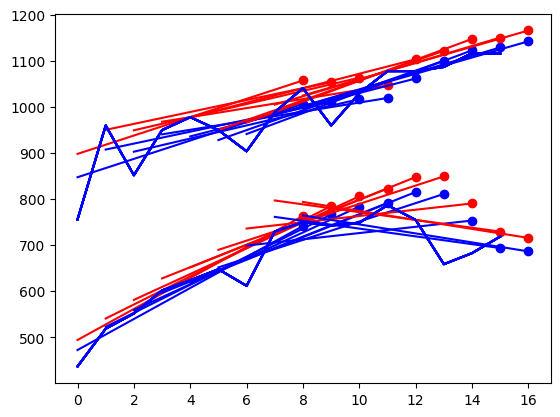

In [20]:
forecast_pivot = pd.DataFrame()
with pd.ExcelWriter(current_dir+'/'+'pivot_plus_forecast.xlsx') as writer:
    for store in df_input['Location'].unique().tolist():
        pivot = pd.DataFrame(columns=['Day'])
        forecasted_ingredients=[]
        for item in units_to_forecast[store]:
            if item in base.sheet_names:
                ingredients = base.parse(sheet_name=item)['Ingredients'].tolist()
                for each in ingredients:
                    if each not in forecasted_ingredients:
                        forecasted_ingredients.append(each)

        for day in df_input['Date'].unique().tolist():
            day_sales = df_pivoting(df_input.loc[(df_input['Date']==day)&(df_input['Location']==store)])
            daily_sales= append_sales_count(pivot, day_sales, day)
        daily_sales.to_excel(writer, sheet_name='{} daily sales'.format(store), index=False)
        print(daily_sales)
        last_week_pivot = df_pivoting(last_week.loc[last_week['Location']==store])
        forecast_pivot = forecast_prep(daily_sales,store,last_week_pivot)
        forecast_pivot.rename(columns={'Weekly':'Quantity'},inplace=True)
        total_forecast = ingredients_pivoting(forecast_pivot, base)

        last_week_ingr = ingredients_pivoting(last_week_pivot,base)
        last_week_ingr.rename(columns={'Qty': 'Last_week'}, inplace=True)
        total_forecast = measure_change(total_forecast,pd.DataFrame(pd.read_csv(current_dir+'/'+'Measure_conversion.csv')), last_week_ingr)
        total_forecast.insert(2, 'Principle', 'Par level')
        for ingredient in forecasted_ingredients:
            total_forecast.loc[total_forecast['Ingredient'] == ingredient,'Principle'] = 'Forecasted'
        total_forecast.to_excel(writer, sheet_name='{} forecast'.format(store), index=False)

And after all data manipulation and forecasting we're left with the output 'pivot_plus_forecast' of by-day sales report and a forecast of use of in ingredients next coming week, with a percentage reference to previous week's sales. This is a direct template sheet for production scheduling, amounts to order. The chart above is an optional display of weekly sales + model fit vs ordinal number of the week, starting from first complete week of sales report. This allows to reflect on performance, merit, trends of items of the menu.

In [21]:
print(total_forecast)

             Ingredient      Qty   Principle Rounded % From last week %  \
0               Chicken      6.0  Forecasted    +6.26%           +3.31%   
1                 Flour   1270.0  Forecasted    +5.01%           +5.48%   
2        Pasterised egg   6350.0  Forecasted    +5.01%           +5.48%   
3           Breadcrumbs   4445.0  Forecasted    +5.01%           +5.48%   
4                  Rice  69841.0  Forecasted    +5.00%           +5.47%   
5               Cabbage     43.0  Forecasted    +6.67%           +7.14%   
6                Ginger   6350.0  Forecasted    +5.01%           +5.48%   
7          Citrus ponzu   6350.0  Forecasted    +5.01%           +5.48%   
8          Spring onion   5080.0  Forecasted    +5.01%           +5.48%   
9             Toncutlet     11.0  Forecasted   +14.19%          +15.79%   
10                Curry     11.0  Forecasted    +5.69%           +5.50%   
11                 Miso      3.0  Forecasted   +48.84%          +49.50%   
12      Pickled raddish  